In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
import pandas as pd

In [11]:
%store -r donnees_2018_hab
%store -r donnees_2018
donnees_2018_hab

,REG,Libellé,MED18,TP6018,D118,D918,RD18,T1_2018,Nb_PN_GN_dep_100k_hab,Crim_Del_PN_GN,Nb_Boucherie_dep_hab,Crim_Del_GN_hab,Crim_Del_PN_hab,Crim_Del_PN_GN_hab
01,Auvergne-Rhône-Alpes,AIN,23420,10.3,12900,44080,3.4,6.4,200.0,26087.0,32.0,3045.0,885.0,3930.0
02,Hauts-de-France,AISNE,19690,18.4,10730,33170,3.1,13.0,300.0,25842.0,22.0,2511.0,2227.0,4739.0
03,Auvergne-Rhône-Alpes,ALLIER,20360,15.5,11360,33600,3.0,9.7,410.0,13416.0,30.0,1578.0,2298.0,3876.0
04,Provence-Alpes-Côte d'Azur,ALPES-DE-HAUTE-PROVENCE,20580,16.8,11060,35380,3.2,11.0,390.0,8367.0,46.0,3326.0,1636.0,4962.0
05,Provence-Alpes-Côte d'Azur,HAUTES-ALPES,20880,13.9,11800,35410,3.0,8.6,450.0,6591.0,47.0,2527.0,2009.0,4536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Île-de-France,ESSONNE,23920,13.1,11880,42180,3.6,7.3,300.0,69610.0,22.0,1184.0,4125.0,5310.0
92,Île-de-France,HAUTS-DE-SEINE,28040,11.9,12220,60580,5.0,7.0,440.0,110533.0,23.0,NaN,6758.0,6758.0
93,Île-de-France,SEINE-SAINT-DENIS,17740,28.4,8910,33960,3.8,12.0,340.0,141638.0,36.0,NaN,8640.0,8640.0
94,Île-de-France,VAL-DE-MARNE,22880,16.6,10790,44900,4.2,8.3,380.0,89604.0,26.0,NaN,6374.0,6374.0


In [12]:
donnees_2018_hab=donnees_2018_hab.drop(columns=['REG', 'Libellé','Crim_Del_PN_GN','Crim_Del_GN_hab','Crim_Del_PN_hab'])



In [ ]:
# donnees_2018_hab=donnees_2018_hab[(donnees_2018_hab.index<'91') & (donnees_2018_hab.index!='75') & (donnees_2018_hab.index!='2A') & (donnees_2018_hab.index!='2B')]

# 1 - Approche économétrique

Dans une première approché économétrique, nous essayons de prédire le nombre de crimes à partir uniquement du nombre de boucherie, puis en rajoutant des variables de contrôles

## 1-A Régression linéaire simple

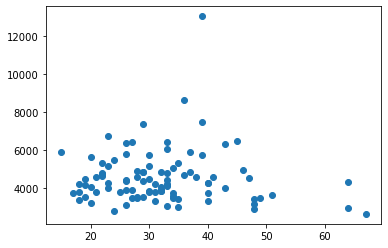

In [22]:
# Code from https://towardsdatascience.com/simulating-replicating-r-regression-plot-in-python-using-sklearn-4ee48a15b67

lm = LinearRegression()

X_train=donnees_2018_hab[[ 'Nb_Boucherie_dep_hab']]
y_train=donnees_2018_hab[['Crim_Del_PN_GN_hab']]

lm.fit(X_train, y_train)


# # for predictions
predictions = lm.predict(X_train)

beta_hat = [lm.intercept_.tolist()] + lm.coef_.tolist()
beta_hat
plt.scatter(X_train, y_train)


In [23]:
reg_with_statsmodels = ols(" Crim_Del_PN_GN_hab ~  Nb_Boucherie_dep_hab", data = donnees_2018_hab).fit()
print(reg_with_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:     Crim_Del_PN_GN_hab   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2105
Date:                Tue, 04 Jan 2022   Prob (F-statistic):              0.647
Time:                        12:15:21   Log-Likelihood:                -832.41
No. Observations:                  96   AIC:                             1669.
Df Residuals:                      94   BIC:                             1674.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4773.8647 

## 1-B Régression linéaire multiple

In [27]:
# Code from https://towardsdatascience.com/simulating-replicating-r-regression-plot-in-python-using-sklearn-4ee48a15b67

lm = LinearRegression()

X_train=donnees_2018_hab[['MED18', 'TP6018', 'D118', 'D918', 'RD18', 'T1_2018',
       'Nb_PN_GN_dep_100k_hab', 'Nb_Boucherie_dep_hab']]
y_train=donnees_2018_hab[['Crim_Del_PN_GN_hab']]

lm.fit(X_train, y_train)



# # for predictions
predictions = lm.predict(X_train)
lm.coef_
lm.intercept_
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores
# R² can be negative with small datasets and cv fold https://stackoverflow.com/questions/23036866/scikit-learn-is-returning-coefficient-of-determination-r2-values-less-than-1

array([0.6639937 , 0.25309168, 0.09378301, 0.72619318, 0.39360204])

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Residual plot')

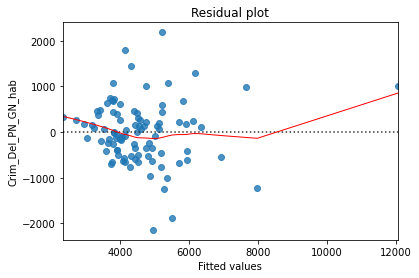

In [28]:


sns.residplot(predictions.reshape(-1),'Crim_Del_PN_GN_hab', data=donnees_2018_hab,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

Text(0.5, 1.0, 'Normal Q-Q Plot')

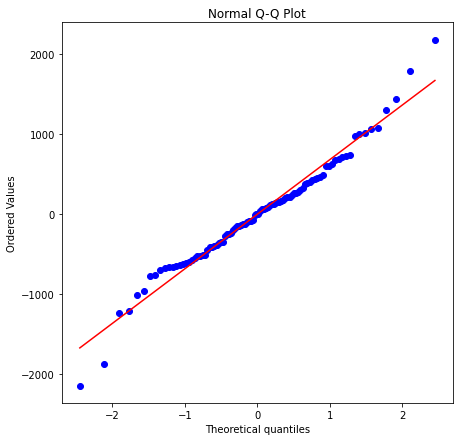

In [30]:
residuals = donnees_2018_hab["Crim_Del_PN_GN_hab"] - predictions.reshape(-1)
residuals

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Fitted value')

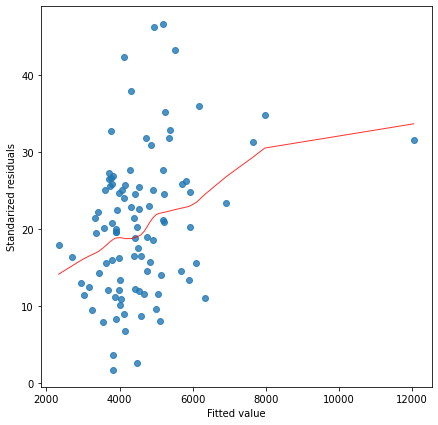

In [31]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(predictions.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

# Hétéroscédasticité
# Woolridge's Introductory Econometrics suggest taking the natural log for : 
# * conditional distributions that are heteroskedastic or skewed;
# * Population variables/  Monetary variables
# * log(1+y) if 0 exists

In [33]:
formula_reg= " Crim_Del_PN_GN_hab ~  Nb_Boucherie_dep_hab + MED18 + TP6018 + D118 + D918 + RD18 + T1_2018 +    Nb_PN_GN_dep_100k_hab"
reg_with_statsmodels = ols( formula_reg, data = donnees_2018_hab).fit()
print(reg_with_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:     Crim_Del_PN_GN_hab   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     36.01
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           1.81e-24
Time:                        12:16:57   Log-Likelihood:                -762.38
No. Observations:                  96   AIC:                             1543.
Df Residuals:                      87   BIC:                             1566.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -5.564e+

In [34]:
new_donnees_2018_hab=donnees_2018_hab
new_donnees_2018_hab['Crim_Del_PN_GN_hab'] = np.log(new_donnees_2018_hab['Crim_Del_PN_GN_hab'])
new_donnees_2018_hab['RD18'] = np.log(new_donnees_2018_hab['RD18'])
new_donnees_2018_hab['D918'] = np.log(new_donnees_2018_hab['D918'])
new_donnees_2018_hab['D118'] = np.log(new_donnees_2018_hab['D118'])
new_donnees_2018_hab['TP6018'] = np.log(new_donnees_2018_hab['TP6018'])
new_donnees_2018_hab['MED18'] = np.log(new_donnees_2018_hab['MED18'])
new_donnees_2018_hab['Nb_Boucherie_dep_hab'] = np.log(new_donnees_2018_hab['Nb_Boucherie_dep_hab'])
new_donnees_2018_hab['Nb_PN_GN_dep_100k_hab'] = np.log(new_donnees_2018_hab['Nb_PN_GN_dep_100k_hab'])
new_donnees_2018_hab['T1_2018'] = np.log(new_donnees_2018_hab['T1_2018'])

formula_reg= " Crim_Del_PN_GN_hab ~  Nb_Boucherie_dep_hab + MED18 + TP6018   + T1_2018 +    Nb_PN_GN_dep_100k_hab"

reg_with_statsmodels = ols( formula_reg, data = new_donnees_2018_hab).fit()
print(reg_with_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:     Crim_Del_PN_GN_hab   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     31.61
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           1.88e-18
Time:                        12:17:48   Log-Likelihood:                 42.253
No. Observations:                  96   AIC:                            -72.51
Df Residuals:                      90   BIC:                            -57.12
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -25.67

# 2 - Approche Machine learning

In [ ]:
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
# Both StandardScaler and MinMaxScaler are very sensitive to the presence of outliers.
# MaxAbsScaler therefore also suffers from the presence of large outliers.


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR


# df_train, df_test = train_test_split(donnees_2018_hab, 
#                                      train_size = 0.7, 
#                                      test_size = 0.3
#                                     )



# pipeline = make_pipeline(RobustScaler(),  SVR(kernel='linear',C=1.0, epsilon=0.2))
# pipeline.fit(X_train, y_train)
# # vA = GridSearchCV(pipeline, param_grid=param_grid,
# #                      scoring='roc_auc', cv=10, refit=True)
# # vA.fit(X_train, y_train)

# print(pipeline.predict(X_test))
# print(y_test)




new_X_train = X_train['Nb_Boucherie_dep_hab']
new_Y_train = y_train
new_X_test= X_test['Nb_Boucherie_dep_hab']
new_Y_test = y_test

sc_X = RobustScaler()
sc_Y = RobustScaler()
X_train_scaled = sc_X.fit_transform(new_X_train.values.reshape(-1, 1))
Y_train_scaled = sc_Y.fit_transform(new_Y_train.values.reshape(-1, 1))
X_test_scaled=sc_X.fit_transform(new_X_test.values.reshape(-1, 1))


svr = SVR(kernel ='linear')
svr.fit(X_train_scaled, Y_train_scaled)
plt.scatter(X_train_scaled, Y_train_scaled, color = 'blue')
plt.scatter(X_train_scaled, svr.predict(X_train_scaled), color = 'red')
plt.title('Crim_Del_PN_GN_hab vs  Nb_Boucherie_dep_hab  (SVR)')
plt.xlabel('Nb_Boucherie_dep_hab')
plt.ylabel('Crim_Del_PN_GN_hab')
plt.show()

print(sc_Y.inverse_transform(svr.predict(X_test_scaled).reshape(-1,1)))
print(new_Y_test)